In [1]:
import torch.nn as nn
import torch.nn.parallel
import random
import argparse
from network.resnet import resnet18, resnet34
from network.pointnet import PointNetCls
from torch.utils.data import DataLoader
import os
import numpy as np
# from data.cifar10_train_val_test import CIFAR10, CIFAR100
from data.cifar10_train_val_test_subset_select import CIFAR10
from data.modelnet40 import ModelNet40
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from termcolor import cprint
# from knn_utils import calc_knn_graph, calc_topo_weights_with_components_idx
from noise import noisify_with_P, noisify_cifar10_asymmetric, noisify_cifar100_asymmetric, noisify_pairflip, noisify_modelnet40_asymmetric
import copy
from scipy.stats import mode
from matplotlib import pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"


# Clean Data

In [2]:
def _init_fn(worker_id):
    np.random.seed(77 + worker_id)


num_epoch = 180
milestone = "60,120"
milestone = [int(x) for x in milestone.split(',')]
batch_size = 512

weight_decay = 1e-4
gamma = 0.5
lr = 0.001
train_val_ratio = 0.8

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = CIFAR10(root='./data', split='train',train_ratio=train_val_ratio, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=_init_fn)

valset = CIFAR10(root='./data', split='val', train_ratio=train_val_ratio,download=True, transform=transform_test)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=0)

testset = CIFAR10(root='./data', split='test',download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

num_classes = 10
in_channel = 3

print('train data size:', len(trainset))
print('validation data size:', len(valset))
print('test data size:', len(testset))
ntrain = len(trainset)

y_train = trainset.get_data_labels()
y_train = np.array(y_train)

# noise_level = 0.4
# random_seed = 42
# noise_y_train, p, keep_indices = noisify_with_P(
#     y_train, nb_classes=num_classes, noise=noise_level, random_state=random_seed)
# trainset.update_corrupted_label(noise_y_train)
# print("apply uniform noise")

torch.manual_seed(77)
net = resnet18(in_channel=in_channel, num_classes=num_classes)
feature_size = 512

optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

################################################
exp_lr_scheduler = lr_scheduler.MultiStepLR(
    optimizer, milestones=milestone, gamma=gamma)

criterion = nn.NLLLoss()  # since the output of network is by log softmax

best_acc = 0
best_epoch = 0

best_accuracy = 0
models_path = "G:\\My Drive\\Research Codes\\Subset Selection Paper\\Neural Network Classifier\\models\\UCI-subset-select\\CIFAR10\\"
unique_labels = [int(i) for i in list(np.linspace(0, 10, 10, endpoint=False))]
torch.manual_seed(77)
avg_loss = []
val_acc = []
train_acc = []
for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = []
    net.train()

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # noisy_train_dl loads in order: idx, input, label, weights, cd_y

        inputs, labels, _, _, _ = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        # outputs, _ = net(inputs.to(device))
        outputs, _ = net(inputs.to(device))
        log_outputs = torch.log_softmax(outputs, 1)

        loss = criterion(log_outputs, labels.long().to(device)).mean()

        loss.backward()
        optimizer.step()
        running_loss.append(loss.item())
    exp_lr_scheduler.step()
    avg_loss.append(torch.tensor(running_loss).mean())
    print("epoch={0:d},  avg_loss = {1:0.4f}".format(
        epoch, torch.tensor(running_loss).mean()))

    if True:
        classes = tuple([str(i) for i in unique_labels])
        correct_pred = {classname: 0 for classname in classes}
        total_pred = {classname: 0 for classname in classes}
        total = 0
        correct = 0

        net.eval()
        with torch.no_grad():
            for data in valloader:
                images, labels, _,_,_ = data
                outputs, _ = net(images.to(device))
                _, predictions = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += (predictions.cpu() == labels).sum().item()
            # collect the correct predictions for each class
                # for label, prediction in zip(labels, predictions):
                #     if label == prediction:
                #         correct_pred[classes[int(label)]] += 1
                #     total_pred[classes[int(label)]] += 1

        # print accuracy for each class
            # for classname, correct_count in correct_pred.items():
            #     accuracy = 100 * np.divide(float(correct_count), total_pred[classname], out=np.zeros(
            #         [1]), where=total_pred[classname] != 0)
            #     print(f'Accuracy for class: {int(float(classname)):d} is {accuracy.item():.1f} %')
            print(f'Accuracy of the network on the validation set: {100 * correct / total} %')
            val_acc.append(100 * correct / total)

    if val_acc[-1] > best_accuracy:
        best_accuracy = val_acc[-1]
        net_path = models_path + "CIFAR10_clean"+".pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val-accuracy': val_acc,
            'train-accuracy': train_acc}, net_path)

    net.eval()
    classes = tuple([str(i) for i in unique_labels])
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    total = 0
    correct = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels, _,_,_ = data
            outputs, _ = net(images.float().to(device))
            _, predictions = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predictions.cpu() == labels).sum().item()
        # collect the correct predictions for each class
            # for label, prediction in zip(labels, predictions):
            #     if label == prediction:
            #         correct_pred[classes[int(label)]] += 1
            #     total_pred[classes[int(label)]] += 1

    # print accuracy for each class
    # for classname, correct_count in correct_pred.items():
    #     accuracy = 100 * np.divide(float(correct_count), total_pred[classname], out=np.zeros(
    #         [1]), where=total_pred[classname] != 0)
    #     print(f'Accuracy for class: {int(float(classname)):d} is {accuracy.item():.1f} %')
    print(f'Accuracy of the network on the train set: {100 * correct / total} %')
    train_acc.append(100 * correct / total)

print('Finished Training')

net_path = models_path + "CIFAR10_clean"+".pth"
best_net_dict = torch.load(net_path)
best_net_dict['val-accuracy'] = val_acc
best_net_dict['train-accuracy'] = train_acc
torch.save(best_net_dict, net_path)

print('Finished Training')


# Noisy Data

In [4]:
def _init_fn(worker_id):
    np.random.seed(77 + worker_id)
    
num_epoch = 180
milestone = "60,120"
milestone = [int(x) for x in milestone.split(',')]
train_batch_size = 512

weight_decay = 1e-4
gamma = 0.5
lr = 0.001
train_val_ratio = 0.8

num_classes = 10
in_channel = 3


# models_path = "G:\\My Drive\\Research Codes\\Subset Selection Paper\\Neural Network Classifier\\models\\UCI-subset-select\\CIFAR10\\"
models_path = ""
unique_labels = [int(i) for i in list(np.linspace(0, 10, 10, endpoint=False))]


# trust_props = [0.2, 0.4, 0.6, 0.8]
trust_props = [0.4, 0.6, 0.8]
noise_levels = [0.2, 0.4, 0.6, 0.8]

for trust_prop in trust_props:
    for noise_level in noise_levels:
        
        print("trust_prop=", trust_prop)
        print("noise_level=", noise_level)
        
        best_acc = 0
        best_epoch = 0
        best_accuracy = 0
        avg_loss = []
        val_acc = []
        train_acc = []
        
        torch.manual_seed(77)
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

        trainset = CIFAR10(root='./data', split='train',train_ratio=train_val_ratio, download=True, transform=transform_train)
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True, num_workers=0, worker_init_fn=_init_fn)

        valset = CIFAR10(root='./data', split='val', train_ratio=train_val_ratio,download=True, transform=transform_test)
        valloader = torch.utils.data.DataLoader(valset, batch_size=train_batch_size, shuffle=False, num_workers=0)

        testset = CIFAR10(root='./data', split='test',download=True, transform=transform_test)
        testloader = torch.utils.data.DataLoader(testset, batch_size=train_batch_size, shuffle=False, num_workers=0)
        
        print('train data size:', len(trainset))
        print('validation data size:', len(valset))
        print('test data size:', len(testset))
        ntrain = len(trainset)

        # y_train = trainset.get_data_labels()
        # y_train = np.array(y_train)

        random_seed = 42
        noise_y_train_labels0, noise_y_train_indices = trainset.get_noisy_labels_with_indices()
        noise_y_train, p, keep_indices = noisify_with_P(noise_y_train_labels0, nb_classes=num_classes, noise=noise_level, random_state=random_seed)
        trainset.update_corrupted_label(noise_y_train, noise_y_train_indices)
        print("apply uniform noise")

        torch.manual_seed(77)
        net = resnet18(in_channel=in_channel, num_classes=num_classes)
        feature_size = 512

        optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        net = net.to(device)

        ################################################
        exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=milestone, gamma=gamma)

        criterion = nn.NLLLoss()  # since the output of network is by log softmax

        for epoch in range(num_epoch):  # loop over the dataset multiple times

            running_loss = []
            net.train()

            for i, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                # noisy_train_dl loads in order: idx, input, label, weights, cd_y

                inputs, labels, _,_,_ = data
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                # outputs, _ = net(inputs.to(device))
                outputs, _ = net(inputs.to(device))
                log_outputs = torch.log_softmax(outputs, 1)

                loss = criterion(log_outputs, labels.long().to(device)).mean()

                loss.backward()
                optimizer.step()
                running_loss.append(loss.item())
            exp_lr_scheduler.step()
            avg_loss.append(torch.tensor(running_loss).mean())
            print("epoch={0:d},  avg_loss = {1:0.4f}".format(
                epoch, torch.tensor(running_loss).mean()))

            if True:
                classes = tuple([str(i) for i in unique_labels])
                correct_pred = {classname: 0 for classname in classes}
                total_pred = {classname: 0 for classname in classes}
                total = 0
                correct = 0

                net.eval()
                with torch.no_grad():
                    for data in valloader:
                        images, labels,_,_,_ = data
                        outputs, _ = net(images.to(device))
                        _, predictions = torch.max(outputs, dim=1)
                        total += labels.size(0)
                        correct += (predictions.cpu() == labels).sum().item()
                    # collect the correct predictions for each class
                        # for label, prediction in zip(labels, predictions):
                        #     if label == prediction:
                        #         correct_pred[classes[int(label)]] += 1
                        #     total_pred[classes[int(label)]] += 1

                # print accuracy for each class
                    # for classname, correct_count in correct_pred.items():
                    #     accuracy = 100 * np.divide(float(correct_count), total_pred[classname], out=np.zeros(
                    #         [1]), where=total_pred[classname] != 0)
                    #     print(f'Accuracy for class: {int(float(classname)):d} is {accuracy.item():.1f} %')
                    print(
                        f'Accuracy of the network on the test set: {100 * correct / total} %')
                    val_acc.append(100 * correct / total)

            if val_acc[-1] > best_accuracy:
                best_accuracy = val_acc[-1]
                net_path = models_path + "CIFAR10_noisy" + "trust_prop={trust_prop:0.2f}".format(trust_prop=trust_prop) +"noise_level={noise_level:0.2f}".format(noise_level=noise_level) + ".pth"
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_accuracy': val_acc,
                    'train-accuracy': train_acc}, net_path)

            net.eval()
            classes = tuple([str(i) for i in unique_labels])
            correct_pred = {classname: 0 for classname in classes}
            total_pred = {classname: 0 for classname in classes}
            total = 0
            correct = 0
            with torch.no_grad():
                for data in trainloader:
                    images, labels, _,_,_ = data
                    outputs, _ = net(images.float().to(device))
                    _, predictions = torch.max(outputs, dim=1)
                    total += labels.size(0)
                    correct += (predictions.cpu() == labels).sum().item()
                # collect the correct predictions for each class
                    # for label, prediction in zip(labels, predictions):
                    #     if label == prediction:
                    #         correct_pred[classes[int(label)]] += 1
                    #     total_pred[classes[int(label)]] += 1

            # print accuracy for each class
            # for classname, correct_count in correct_pred.items():
            #     accuracy = 100 * np.divide(float(correct_count), total_pred[classname], out=np.zeros(
            #         [1]), where=total_pred[classname] != 0)
            #     print(f'Accuracy for class: {int(float(classname)):d} is {accuracy.item():.1f} %')
            print(f'Accuracy of the network on the train set: {100 * correct / total} %')
            train_acc.append(100 * correct / total)

        print('Finished Training')

        net_path = models_path + models_path + "CIFAR10_noisy" + "trust_prop={trust_prop:0.2f}".format(trust_prop=trust_prop) +"noise_level={noise_level:0.2f}".format(noise_level=noise_level) + ".pth"
        best_net_dict = torch.load(net_path)
        best_net_dict['val_accuracy'] = val_acc
        best_net_dict['train_accuracy'] = train_acc
        torch.save(best_net_dict, net_path)

        print('Finished Training')


Files already downloaded and verified
test set accuraccy: 86.05 %
test set accuraccy: 84.2 %
test set accuraccy: 81.25 %
test set accuraccy: 79.35 %
test set accuraccy: 86.25 %
test set accuraccy: 84.14 %
test set accuraccy: 81.83 %
test set accuraccy: 80.58 %
test set accuraccy: 86.28 %
test set accuraccy: 84.38 %
test set accuraccy: 81.44 %
test set accuraccy: 78.39 %
test set accuraccy: 86.37 %
test set accuraccy: 82.97 %
test set accuraccy: 81.58 %
test set accuraccy: 78.31 %


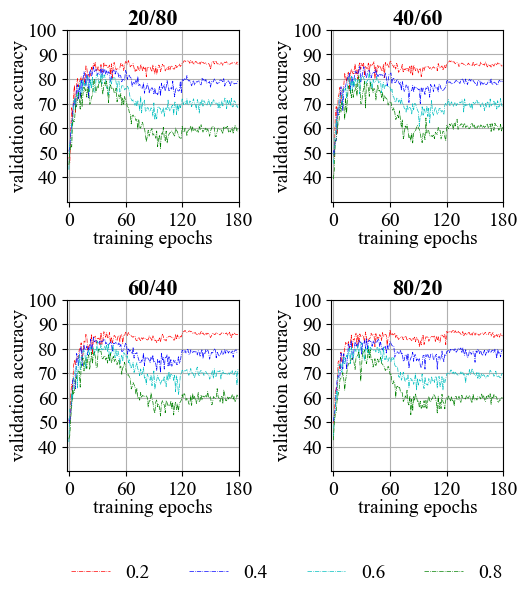

In [13]:
import pandas as pd
import matplotlib
font = {'family': 'Times New Roman',
        'size'   : 14}
font1 = {'family': 'Times New Roman',
        'size'   : 14}

matplotlib.rc('font', **font)

trust_props = [0.2, 0.4, 0.6, 0.8]
noise_levels = [0.2, 0.4, 0.6, 0.8]
max_epochs = 180
fig, axs = plt.subplots(2, 2, figsize=(5.5, 6.6), tight_layout=True)

max_val_accs = np.zeros([len(trust_props), len(noise_levels)])
max_test_accs = np.zeros([len(trust_props), len(noise_levels)])

test_transform = transform_test = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

testset = CIFAR10(root='./data', split='test',
                  download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=0)
unique_labels = [0,1,2,3,4,5,6,7,8,9]

# G: \My Drive\Research Codes\Subset Selection Paper\Neural Network Classifier\USPS\CIFAR10\test on noisy data\Lambda tests\ss_1 cifar10 c = 20trust_prop = 0.40noise_level = 0.20.pth

models_path = ""
in_channel = 3
num_classes = 10


line_colors = ['r', 'b', 'c', 'g']
for i in range(len(trust_props)):
    for j in range(len(noise_levels)):
        trust_prop = trust_props[i]
        noise_level = noise_levels[j]
        net_path = models_path + "CIFAR10_noisy" + "trust_prop={trust_prop:0.2f}".format(
            trust_prop=trust_prop) + "noise_level={noise_level:0.2f}".format(noise_level=noise_level) + ".pth"
        best_net_dict = torch.load(net_path)
        net = resnet18(in_channel=in_channel, num_classes=num_classes).to(device)
        net.load_state_dict(best_net_dict['model_state_dict'])
        
        classes = tuple([str(i) for i in unique_labels])
        correct_pred = {classname: 0 for classname in classes}
        total_pred = {classname: 0 for classname in classes}
        total = 0
        correct = 0

        net.eval()
        with torch.no_grad():
            for data in testloader:
                images, labels, _, _, _ = data
                outputs, _ = net(images.to(device))
                _, predictions = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += (predictions.cpu() == labels).sum().item()
            print(f'test set accuraccy: {100 * correct / total} %')
        max_test_accs[i, j] = 100 * correct / total
        
        
        acc_ci = best_net_dict["val_accuracy"]
        max_val_accs[i,j] = max(acc_ci)
        acc_ci = np.array([i/100 for i in acc_ci])
        iters = np.linspace(0, max_epochs, max_epochs, endpoint=False)
        # label_str = "{trust_prop:0.0f}%".format(trust_prop=int(100*trust_prop)) + " {noise_level:0.1f}".format(noise_level=noise_level)
        label_str = "{noise_level:0.1f}".format(noise_level=noise_level)
        if i != len(trust_props)-1:
            axs.flatten()[i].plot(iters, 100*acc_ci, color = line_colors[j], linestyle="-.", linewidth=0.5)
        else:
            axs.flatten()[i].plot(iters, 100*acc_ci, color=line_colors[j], linestyle="-.", label=label_str, linewidth=0.5)
            
    title_str = str(int(100*trust_prop)) + "/" + str(int(100 - 100*trust_prop))
    axs.flatten()[i].set_title(title_str, font = {'weight' : 'bold', 'size':16}, pad = 0)
    axs.flatten()[i].set_xlabel("training epochs", labelpad=0.01, **font)
    axs.flatten()[i].set_ylabel("validation accuracy", labelpad=0.01, **font)
    axs.flatten()[i].set_xlim([-2,180])
    axs.flatten()[i].set_yticks([40, 50, 60, 70, 80, 90, 100], **font)
    axs.flatten()[i].set_xticks([0, 60, 120, 180], **font)
    axs.flatten()[i].set_ylim([30,100])
    axs.flatten()[i].grid()
    axs.flatten()[i].set_box_aspect(1)
    # axs.flatten()[i].legend(ncol=1, prop =font1)
fig.legend(loc = (0.12,0.001), prop =font1, ncol=4, frameon=False)
# fig.tight_layout()
max_val_accs_df = pd.DataFrame(max_val_accs, index = [int(100*i) for i in trust_props], columns = noise_levels)
max_test_accs_df = pd.DataFrame(max_test_accs, index = [int(100*i) for i in trust_props], columns = noise_levels)

file_name1 = "CIFAR10" + "noisy_val_accuracies"+".pdf"
file_name2 = "CIFAR10" + "noisy_val_accuracies"+".svg"
file_name3 = "CIFAR10" + "noisy_val_accuracies"+".png"

fig.savefig(file_name1, dpi=500, bbox_inches='tight', format='pdf')
fig.savefig(file_name2, dpi=500, bbox_inches='tight', format='svg')
fig.savefig(file_name3, dpi=500, bbox_inches='tight', format='png')


In [16]:
max_val_accs_df

,0.2,0.4,0.6,0.8
20,87.59,84.97,82.33,80.12
40,87.50,85.27,82.86,81.35
60,87.46,84.62,83.02,79.78
80,87.64,84.21,82.44,79.58


In [17]:
max_test_accs_df

,0.2,0.4,0.6,0.8
20,86.05,84.20,81.25,79.35
40,86.25,84.14,81.83,80.58
60,86.28,84.38,81.44,78.39
80,86.37,82.97,81.58,78.31


# Subset Selection Method

In [ ]:
# import torch.nn.functional as F
# from subset_select_non_uniform_entropic_FISTA_git import subset_select_non_uniform_FISTA as ss
# from subset_select_ipot_non_uniform_git import subset_select_ipot as ss_ipot

# def _init_fn(worker_id):
#     np.random.seed(77 + worker_id)

# # models_path = "G:\\My Drive\\Research Codes\\Subset Selection Paper\\Neural Network Classifier\\models\\UCI-subset-select\\CIFAR10\\"
# models_path = ""

# torch.manual_seed(77)
# batch_size_train = 512

# in_channel = 3
# num_classes = 10
# # batch_size = 512
# batch_size_train = batch_size_train
# train_val_ratio = 0.8

# unique_labels = [int(i) for i in list(np.linspace(0, 10, 10, endpoint=False))]
# cs = [20]
# # cs = [200]
# accuracies = []



# # max_epochs = 180
# # weight_update_iter = 5
# # min_update_iter = 20

# # weight_decay = 1e-4
# # gamma_lr = 0.5
# # lr = 0.001

# max_epochs = 180
# weight_update_iter = 5
# min_update_iter = 50

# weight_decay = 1e-4
# gamma_lr = 0.5
# lr = 0.001

# miltestones = [60, 120]
# gamma_ss = 0.01

# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])
# trust_props = [0.2, 0.4, 0.6, 0.8]
# noise_levels = [0.2, 0.4, 0.6, 0.8]



# for c_k in range(len(cs)):
#     for trust_prop in trust_props:
#         for noise_level in noise_levels:
#             c = cs[c_k]

#             val_acc_best = 0
#             val_acc = []
#             train_acc = []
#             avg_loss = []

#             print("c=", c)
#             print("trust_prop=", trust_prop)
#             print("noise level=", noise_level)
#             torch.manual_seed(77)
#             net = resnet18(in_channel=in_channel, num_classes=num_classes).to(device)
#             # noisy_train_ds = JointDataset(X_ds, y_ds, w_ds.clone().detach(), cdy_ds)
#             # noisy_train_dl = DataLoader(noisy_train_ds, batch_size=batch_size_train,
#             #                             shuffle=True, num_workers=0, generator=torch.manual_seed(42))

#             trainset = CIFAR10(root='./data', split='train', train_ratio=train_val_ratio,trust_prop=trust_prop, download=True, transform=transform_train)
#             trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train, shuffle=True, num_workers=0, worker_init_fn=_init_fn)

#             # noise_level = 0.8
#             random_seed = 42
#             noise_y_train_labels0, noise_y_train_indices = trainset.get_noisy_labels_with_indices()
#             noise_y_train, p, _ = noisify_with_P(noise_y_train_labels0, nb_classes=num_classes, noise=noise_level, random_state=random_seed)
#             trainset.update_corrupted_label(noise_y_train, noise_y_train_indices)

#             valset = CIFAR10(root='./data', split='val', train_ratio=train_val_ratio,trust_prop=trust_prop, download=True, transform=transform_test)
#             valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size_train, shuffle=False, num_workers=0)

#             testset = CIFAR10(root='./data', split='test',download=True, transform=transform_test)
#             testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size_train, shuffle=False, num_workers=0)
#             torch.manual_seed(0)
#             optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
#             exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=miltestones, gamma=gamma_lr)
#             # criterion = nn.NLLLoss(reduction='none')

#             for epoch in range(max_epochs):  # loop over the dataset multiple times
#                 running_loss = []
#                 net.train()
#                 for i, data in enumerate(trainloader, 0):
#                     # get the inputs; data is a list of [inputs, labels]
#                     inputs, labels, weights, cd_y, idx = data
#                     # zero the parameter gradients
#                     optimizer.zero_grad()
#                     # forward + backward + optimize
#                     outputs, encodings = net(inputs.to(device))
#                     x = encodings[cd_y == 1].detach().cpu()
#                     y = encodings[cd_y == 0].detach().cpu()
#                     x_labels = labels[cd_y == 1].detach().cpu()
#                     y_labels = labels[cd_y == 0].detach().cpu()
#                     x_idx = idx[cd_y == 1].detach().cpu()
#                     y_idx = idx[cd_y == 0].detach().cpu()

#                     x_labels_onehot = (F.one_hot(x_labels.long(), num_classes=num_classes)).to(device).double()

#                     mu = 1/x.shape[0]*np.ones(x.shape[0])
#                     nu = 1/y.shape[0]*np.ones(y.shape[0])
#                     costs, P, _, _ = ss_ipot(x, y, mu, nu, c,  gamma_ss, max_outer_iter=20,max_inner_iter=20, wd=2, disp_iter=False, return_map=True)

#                     P_torch = torch.from_numpy(P).to(device)
#                     y_labels_hat = (P_torch.T@x_labels_onehot.double()).to(device)

#                     input_labels_hat = torch.zeros_like(outputs, device=device, dtype=torch.double)
#                     input_labels_hat[cd_y == 1] = 1 / x.shape[0] * (x_labels_onehot.double())
#                     input_labels_hat[cd_y == 0] = y_labels_hat

#                     loss = - torch.sum(input_labels_hat*F.log_softmax(outputs, dim=1))
#                     loss.backward()
#                     optimizer.step()
#                     running_loss.append(loss.item())

#                 avg_loss.append(torch.tensor(running_loss).mean())
#                 print("epoch={0:d},  avg_loss = {1:0.4f}".format(
#                     epoch, torch.tensor(running_loss).mean()))

#                 # lr scheduler update
#                 exp_lr_scheduler.step()

#                 if True:
#                     classes = tuple([str(i) for i in unique_labels])
#                     correct_pred = {classname: 0 for classname in classes}
#                     total_pred = {classname: 0 for classname in classes}
#                     total = 0
#                     correct = 0

#                     net.eval()
#                     with torch.no_grad():
#                         for data in valloader:
#                             images, labels, _ , _, _ = data
#                             outputs, _ = net(images.to(device))
#                             _, predictions = torch.max(outputs, dim=1)
#                             total += labels.size(0)
#                             correct += (predictions.cpu() == labels).sum().item()
#                         # collect the correct predictions for each class
#                             # for label, prediction in zip(labels, predictions):
#                             #     if label == prediction:
#                             #         correct_pred[classes[int(label)]] += 1
#                             #     total_pred[classes[int(label)]] += 1

#                     # print accuracy for each class
#                     # for classname, correct_count in correct_pred.items():
#                     #     accuracy = 100 * np.divide(float(correct_count), total_pred[classname], out=np.zeros(
#                     #         [1]), where=total_pred[classname] != 0)
#                         # print(f'Accuracy for class: {int(float(classname)):d} is {accuracy.item():.1f} %')
#                     # print(f'Accuracy of the network on the test set: {100 * correct / total} %')
#                     print(f'Val. Accuracy: {100 * correct / total} %')

#                     val_acc.append(100 * correct / total)

#                 net.eval()
#                 classes = tuple([str(i) for i in unique_labels])
#                 correct_pred = {classname: 0 for classname in classes}
#                 total_pred = {classname: 0 for classname in classes}
#                 total = 0
#                 correct = 0
#                 with torch.no_grad():
#                     for data in trainloader:
#                         images, labels, _,_,_ = data
#                         outputs, _ = net(images.float().to(device))
#                         _, predictions = torch.max(outputs, dim=1)
#                         total += labels.size(0)
#                         correct += (predictions.cpu() == labels).sum().item()
#                     # collect the correct predictions for each class
#                         # for label, prediction in zip(labels, predictions):
#                         #     if label == prediction:
#                         #         correct_pred[classes[int(label)]] += 1
#                         #     total_pred[classes[int(label)]] += 1

#                 # print accuracy for each class
#                 # for classname, correct_count in correct_pred.items():
#                 #     accuracy = 100 * np.divide(float(correct_count), total_pred[classname], out=np.zeros(
#                 #         [1]), where=total_pred[classname] != 0)
#                 #     print(f'Accuracy for class: {int(float(classname)):d} is {accuracy.item():.1f} %')
#                 print(f'Accuracy of the network on the train set: {100 * correct / total} %')
#                 train_acc.append(100 * correct / total)

#                 # print('Finished Training')


#                 if val_acc[-1] > val_acc_best:
#                     val_acc_best = val_acc[-1]
#                     net_path = models_path + "ss_1 " + "cifar10 " + "c={cs:1d}".format(cs=c) + "trust_prop={trust_prop:0.2f}".format(trust_prop=trust_prop) +"noise_level={noise_level:0.2f}".format(noise_level=noise_level) + ".pth"
#                     torch.save({'epoch': epoch,
#                                 'model_state_dict': net.state_dict(),
#                                 'optimizer_state_dict': optimizer.state_dict(),
#                                 'val_accuracy': val_acc,
#                                 'train_accuracy': train_acc
#                                 }, net_path)

#             # print('Finished Training')

#             net_path = models_path + "ss_1 " + "cifar10 " + "c={cs:1d}".format(cs=c) + "trust_prop={trust_prop:0.2f}".format(trust_prop=trust_prop) +"noise_level={noise_level:0.2f}".format(noise_level=noise_level) + ".pth"
#             best_net_dict = torch.load(net_path)
#             best_net_dict['val_accuracy'] = val_acc
#             best_net_dict['train_accuracy'] = train_acc
#             torch.save(best_net_dict, net_path)


In [ ]:
# for c in cs:
#     net_path = models_path + "ss_1 " +  "cifar10 " + "c={cs:1d}".format(cs=c)+".pth"
#     best_net_dict = torch.load(net_path)
#     best_net_dict['val_accuracy'] = best_net_dict['accuracy']
#     best_net_dict['train_accuracy'] = train_acc
#     torch.save(best_net_dict, net_path)
    

# c = 2

Files already downloaded and verified
test set accuraccy: 82.69 %
test set accuraccy: 82.56 %
test set accuraccy: 82.16 %
test set accuraccy: 82.37 %
test set accuraccy: 86.41 %
test set accuraccy: 86.85 %
test set accuraccy: 86.4 %
test set accuraccy: 86.74 %
test set accuraccy: 89.09 %
test set accuraccy: 88.49 %
test set accuraccy: 88.84 %
test set accuraccy: 88.26 %
test set accuraccy: 89.31 %
test set accuraccy: 89.42 %
test set accuraccy: 89.36 %
test set accuraccy: 89.22 %


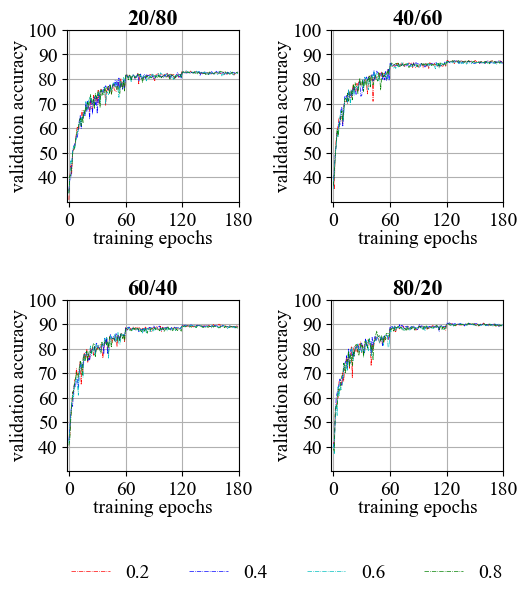

In [18]:
import pandas as pd
import matplotlib
font = {'family': 'Times New Roman',
        'size'   : 14}
font1 = {'family': 'Times New Roman',
        'size'   : 14}

matplotlib.rc('font', **font)
c = 2
trust_props = [0.2, 0.4, 0.6, 0.8]
noise_levels = [0.2, 0.4, 0.6, 0.8]
max_epochs = 180
fig, axs = plt.subplots(2, 2, figsize=(5.5, 6.6), tight_layout=True)

max_val_accs = np.zeros([len(trust_props), len(noise_levels)])
max_test_accs = np.zeros([len(trust_props), len(noise_levels)])

test_transform = transform_test = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])

testset = CIFAR10(root='./data', split='test',
                  download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=0)
unique_labels = [0,1,2,3,4,5,6,7,8,9]

# G: \My Drive\Research Codes\Subset Selection Paper\Neural Network Classifier\USPS\CIFAR10\test on noisy data\Lambda tests\ss_1 cifar10 c = 20trust_prop = 0.40noise_level = 0.20.pth

models_path = ""
in_channel = 3
num_classes = 10


line_colors = ['r', 'b', 'c', 'g']
for i in range(len(trust_props)):
    for j in range(len(noise_levels)):
        trust_prop = trust_props[i]
        noise_level = noise_levels[j]
        net_path = "ss_1 " + "cifar10 " + "c={cs:1d}".format(cs=c) + "trust_prop={trust_prop:0.2f}".format(trust_prop=trust_prop) + "noise_level={noise_level:0.2f}".format(noise_level=noise_level) + ".pth"
        best_net_dict = torch.load(net_path)
        net = resnet18(in_channel=in_channel, num_classes=num_classes).to(device)
        net.load_state_dict(best_net_dict['model_state_dict'])
        
        classes = tuple([str(i) for i in unique_labels])
        correct_pred = {classname: 0 for classname in classes}
        total_pred = {classname: 0 for classname in classes}
        total = 0
        correct = 0

        net.eval()
        with torch.no_grad():
            for data in testloader:
                images, labels, _, _, _ = data
                outputs, _ = net(images.to(device))
                _, predictions = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += (predictions.cpu() == labels).sum().item()
            print(f'test set accuraccy: {100 * correct / total} %')
        max_test_accs[i, j] = 100 * correct / total
        
        
        acc_ci = best_net_dict["val_accuracy"]
        max_val_accs[i,j] = max(acc_ci)
        acc_ci = np.array([i/100 for i in acc_ci])
        iters = np.linspace(0, max_epochs, max_epochs, endpoint=False)
        # label_str = "{trust_prop:0.0f}%".format(trust_prop=int(100*trust_prop)) + " {noise_level:0.1f}".format(noise_level=noise_level)
        label_str = "{noise_level:0.1f}".format(noise_level=noise_level)
        if i != len(trust_props)-1:
            axs.flatten()[i].plot(iters, 100*acc_ci, color = line_colors[j], linestyle="-.", linewidth=0.5)
        else:
            axs.flatten()[i].plot(iters, 100*acc_ci, color=line_colors[j], linestyle="-.", label=label_str, linewidth=0.5)
            
    title_str = str(int(100*trust_prop)) + "/" + str(int(100 - 100*trust_prop))
    axs.flatten()[i].set_title(title_str, font = {'weight' : 'bold', 'size':16}, pad = 0)
    axs.flatten()[i].set_xlabel("training epochs", labelpad=0.01, **font)
    axs.flatten()[i].set_ylabel("validation accuracy", labelpad=0.01, **font)
    axs.flatten()[i].set_xlim([-2,180])
    axs.flatten()[i].set_yticks([40, 50, 60, 70, 80, 90, 100], **font)
    axs.flatten()[i].set_xticks([0, 60, 120, 180], **font)
    axs.flatten()[i].set_ylim([30,100])
    axs.flatten()[i].grid()
    axs.flatten()[i].set_box_aspect(1)
    # axs.flatten()[i].legend(ncol=1, prop =font1)
fig.legend(loc = (0.12,0.001), prop =font1, ncol=4, frameon=False)
# fig.tight_layout()
max_val_accs_df = pd.DataFrame(max_val_accs, index = [int(100*i) for i in trust_props], columns = noise_levels)
max_test_accs_df = pd.DataFrame(max_test_accs, index = [int(100*i) for i in trust_props], columns = noise_levels)

file_name1 = "CIFAR10" + "ss_val_accuracies"+ "c={cs:1d}".format(cs=c) + ".pdf"
file_name2 = "CIFAR10" + "ss_val_accuracies"+"c={cs:1d}".format(cs=c)+".svg"
file_name3 = "CIFAR10" + "ss_val_accuracies"+"c={cs:1d}".format(cs=c)+".png"

fig.savefig(file_name1, dpi=500, bbox_inches='tight', format='pdf')
fig.savefig(file_name2, dpi=500, bbox_inches='tight', format='svg')
fig.savefig(file_name3, dpi=500, bbox_inches='tight', format='png')


In [18]:
max_val_accs_df

,0.2,0.4,0.6,0.8
20,83.27,83.27,83.56,83.21
40,87.65,87.53,87.28,87.62
60,89.95,89.72,89.70,89.39
80,90.43,90.49,90.16,90.44


In [19]:
max_test_accs_df

,0.2,0.4,0.6,0.8
20,82.69,82.56,82.16,82.37
40,86.41,86.85,86.40,86.74
60,89.09,88.49,88.84,88.26
80,89.31,89.42,89.36,89.22


# c=20

Files already downloaded and verified
test set accuraccy: 82.32 %
test set accuraccy: 81.98 %
test set accuraccy: 81.92 %
test set accuraccy: 81.45 %
test set accuraccy: 86.73 %
test set accuraccy: 86.65 %
test set accuraccy: 87.16 %
test set accuraccy: 86.49 %
test set accuraccy: 88.72 %
test set accuraccy: 89.41 %
test set accuraccy: 89.17 %
test set accuraccy: 88.73 %
test set accuraccy: 89.78 %
test set accuraccy: 89.97 %
test set accuraccy: 90.08 %
test set accuraccy: 89.54 %


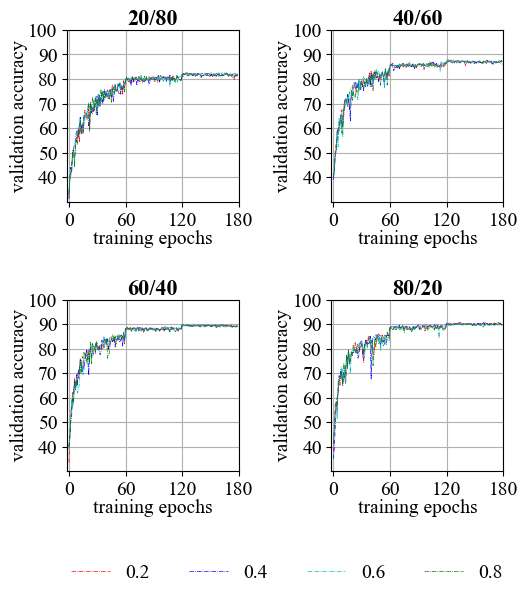

In [22]:
import pandas as pd
import matplotlib
font = {'family': 'Times New Roman',
        'size': 14}
font1 = {'family': 'Times New Roman',
         'size': 14}

matplotlib.rc('font', **font)
c = 20
trust_props = [0.2, 0.4, 0.6, 0.8]
noise_levels = [0.2, 0.4, 0.6, 0.8]
max_epochs = 180
fig, axs = plt.subplots(2, 2, figsize=(5.5, 6.6), tight_layout=True)

max_val_accs = np.zeros([len(trust_props), len(noise_levels)])
max_test_accs = np.zeros([len(trust_props), len(noise_levels)])

test_transform = transform_test = transforms.Compose([transforms.ToTensor(
), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), ])

testset = CIFAR10(root='./data', split='test',download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=0)
unique_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# G: \My Drive\Research Codes\Subset Selection Paper\Neural Network Classifier\USPS\CIFAR10\test on noisy data\Lambda tests\ss_1 cifar10 c = 20trust_prop = 0.40noise_level = 0.20.pth

models_path = ""
in_channel = 3
num_classes = 10


line_colors = ['r', 'b', 'c', 'g']
for i in range(len(trust_props)):
    for j in range(len(noise_levels)):
        trust_prop = trust_props[i]
        noise_level = noise_levels[j]
        net_path = "ss_1 " + "cifar10 " + "c={cs:1d}".format(cs=c) + "trust_prop={trust_prop:0.2f}".format(
            trust_prop=trust_prop) + "noise_level={noise_level:0.2f}".format(noise_level=noise_level) + ".pth"
        best_net_dict = torch.load(net_path)
        net = resnet18(in_channel=in_channel,
                       num_classes=num_classes).to(device)
        net.load_state_dict(best_net_dict['model_state_dict'])

        classes = tuple([str(i) for i in unique_labels])
        correct_pred = {classname: 0 for classname in classes}
        total_pred = {classname: 0 for classname in classes}
        total = 0
        correct = 0

        net.eval()
        with torch.no_grad():
            for data in testloader:
                images, labels, _, _, _ = data
                outputs, _ = net(images.to(device))
                _, predictions = torch.max(outputs, dim=1)
                total += labels.size(0)
                correct += (predictions.cpu() == labels).sum().item()
            print(f'test set accuraccy: {100 * correct / total} %')
        max_test_accs[i, j] = 100 * correct / total

        acc_ci = best_net_dict["val_accuracy"]
        max_val_accs[i, j] = max(acc_ci)
        acc_ci = np.array([i/100 for i in acc_ci])
        iters = np.linspace(0, max_epochs, max_epochs, endpoint=False)
        # label_str = "{trust_prop:0.0f}%".format(trust_prop=int(100*trust_prop)) + " {noise_level:0.1f}".format(noise_level=noise_level)
        label_str = "{noise_level:0.1f}".format(noise_level=noise_level)
        if i != len(trust_props)-1:
            axs.flatten()[i].plot(iters, 100*acc_ci, color=line_colors[j], linestyle="-.", linewidth=0.5)
        else:
            axs.flatten()[i].plot(iters, 100*acc_ci, color=line_colors[j], linestyle="-.", label=label_str, linewidth=0.5)

    title_str = str(int(100*trust_prop)) + "/" + str(int(100 - 100*trust_prop))
    axs.flatten()[i].set_title(title_str, font={'weight': 'bold', 'size': 16}, pad=0)
    axs.flatten()[i].set_xlabel("training epochs", labelpad=0.01, **font)
    axs.flatten()[i].set_ylabel("validation accuracy", labelpad=0.01, **font)
    axs.flatten()[i].set_xlim([-2, 180])
    axs.flatten()[i].set_yticks([40, 50, 60, 70, 80, 90, 100], **font)
    axs.flatten()[i].set_xticks([0, 60, 120, 180], **font)
    axs.flatten()[i].set_ylim([30, 100])
    axs.flatten()[i].grid()
    axs.flatten()[i].set_box_aspect(1)
    # axs.flatten()[i].legend(ncol=1, prop =font1)
fig.legend(loc=(0.12, 0.001), prop=font1, ncol=4, frameon=False)
# fig.tight_layout()
max_val_accs_df = pd.DataFrame(max_val_accs, index=[int(100*i) for i in trust_props], columns=noise_levels)
max_test_accs_df = pd.DataFrame(max_test_accs, index=[int(100*i) for i in trust_props], columns=noise_levels)

file_name1 = "CIFAR10" + "ss_val_accuracies"+ "c={cs:1d}".format(cs=c) + ".pdf"
file_name2 = "CIFAR10" + "ss_val_accuracies"+"c={cs:1d}".format(cs=c)+".svg"
file_name3 = "CIFAR10" + "ss_val_accuracies"+"c={cs:1d}".format(cs=c)+".png"

fig.savefig(file_name1, dpi=500, bbox_inches='tight', format='pdf')
fig.savefig(file_name2, dpi=500, bbox_inches='tight', format='svg')
fig.savefig(file_name3, dpi=500, bbox_inches='tight', format='png')


In [21]:
max_test_accs_df


,0.2,0.4,0.6,0.8
20,82.32,81.98,81.92,81.45
40,86.73,86.65,87.16,86.49
60,88.72,89.41,89.17,88.73
80,89.78,89.97,90.08,89.54


In [23]:
max_val_accs_df


,0.2,0.4,0.6,0.8
20,82.43,82.52,82.82,82.56
40,87.36,87.64,87.91,87.66
60,89.83,89.98,89.90,89.73
80,90.69,90.54,90.35,90.38


# Subset Selection Method-II Labels

In [ ]:
# import torch.nn.functional as F
# from subset_select_non_uniform_entropic_FISTA_git import subset_select_non_uniform_FISTA as ss
# from subset_select_ipot_non_uniform_git import subset_select_ipot as ss_ipot

# def _init_fn(worker_id):
#     np.random.seed(77 + worker_id)

# models_path = "G:\\My Drive\\Research Codes\\Subset Selection Paper\\Neural Network Classifier\\models\\UCI-subset-select\\CIFAR10\\"
# torch.manual_seed(77)
# batch_size_train = 128
# batch_size_val = 128

# in_channel = 3
# num_classes = 10
# num_class = 10
# batch_size_train = batch_size_train
# train_val_ratio = 0.8

# unique_labels = [int(i) for i in list(np.linspace(0, 10, 10, endpoint=False))]
# # cs = [1, 2, 3, 4, 5, 6, 7, 8, 20]
# cs = [8]
# # cs = [200]
# accuracies = []
# batch_size = 1024

# # max_epochs = 180
# # weight_update_iter = 5
# # min_update_iter = 20

# # weight_decay = 1e-4
# # gamma_lr = 0.5
# # lr = 0.001

# max_epochs = 180
# weight_update_iter = 5
# min_update_iter = 50

# weight_decay = 1e-4
# gamma_lr = 0.5
# lr = 0.001

# miltestones = [60, 120]
# gamma_ss = 0.01

# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])

# for c_k in range(len(cs)):
#     c = cs[c_k]

#     val_acc_best = 0
#     val_acc = []
#     train_acc = []
#     avg_loss = []

#     print("c=", c)
#     torch.manual_seed(77)
#     net = resnet18(in_channel=in_channel, num_classes=num_classes).to(device)
#     # noisy_train_ds = JointDataset(X_ds, y_ds, w_ds.clone().detach(), cdy_ds)
#     # noisy_train_dl = DataLoader(noisy_train_ds, batch_size=batch_size_train,
#     #                             shuffle=True, num_workers=0, generator=torch.manual_seed(42))

#     trainset = CIFAR10(root='./data', split='train', train_ratio=train_val_ratio,trust_prop=0.5, download=True, transform=transform_train)
#     trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size_train, shuffle=True, num_workers=0, worker_init_fn=_init_fn)

#     noise_level = 0.8
#     random_seed = 42
#     noise_y_train_labels0, noise_y_train_indices = trainset.get_noisy_labels_with_indices()
#     noise_y_train, p, _ = noisify_with_P(noise_y_train_labels0, nb_classes=num_classes, noise=noise_level, random_state=random_seed)
#     trainset.update_corrupted_label(noise_y_train, noise_y_train_indices)

#     valset = CIFAR10(root='./data', split='val', train_ratio=train_val_ratio, trust_prop=0.5, download=True, transform=transform_test)
#     valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size_val, shuffle=False, num_workers=0)

#     testset = CIFAR10(root='./data', split='test',download=True, transform=transform_test)
#     testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)
#     torch.manual_seed(0)
#     optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
#     exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=miltestones, gamma=gamma_lr)
#     # criterion = nn.NLLLoss(reduction='none')

#     for epoch in range(max_epochs):  # loop over the dataset multiple times
#         running_loss = []
#         net.train()
#         for i, data in enumerate(trainloader, 0):
#             # get the inputs; data is a list of [inputs, labels]
#             inputs, labels, weights, cd_y, idx = data
#             # zero the parameter gradients
#             optimizer.zero_grad()
#             # forward + backward + optimize
#             outputs, encodings = net(inputs.to(device))
#             x = encodings[cd_y == 1].detach().cpu()
#             y = encodings[cd_y == 0].detach().cpu()
#             x_labels = labels[cd_y == 1].detach().cpu()
#             y_labels = labels[cd_y == 0].detach().cpu()
#             x_idx = idx[cd_y == 1].detach().cpu()
#             y_idx = idx[cd_y == 0].detach().cpu()

#             x_labels_onehot = (F.one_hot(x_labels.long(), num_classes=num_classes)).to(device).double()

#             mu = 1/x.shape[0]*np.ones(x.shape[0])
#             nu = 1/y.shape[0]*np.ones(y.shape[0])
#             costs, P, _, _ = ss_ipot(x, y, mu, nu, c,  gamma_ss, max_outer_iter=20, max_inner_iter=20, wd=2, disp_iter=False, return_map=True)

#             P_torch = torch.from_numpy(P).to(device)
#             # y_labels_hat = (P_torch.T@x_labels_onehot.double()).to(device)
#             y_labels_hat = (1 / y.shape[0] * F.one_hot(torch.argmax(P_torch.T@x_labels_onehot.double(), 1), 10)).to(device)

#             input_labels_hat = torch.zeros_like(outputs, device=device, dtype=torch.double)
#             input_labels_hat[cd_y == 1] = 1 / x.shape[0] * (x_labels_onehot.double())
#             input_labels_hat[cd_y == 0] = y_labels_hat.double()

#             loss = - torch.sum(input_labels_hat*F.log_softmax(outputs, dim=1))
#             loss.backward()
#             optimizer.step()
#             running_loss.append(loss.item())

#         avg_loss.append(torch.tensor(running_loss).mean())
#         print("epoch={0:d},  avg_loss = {1:0.4f}".format(
#             epoch, torch.tensor(running_loss).mean()))

#         # lr scheduler update
#         exp_lr_scheduler.step()

#         if True:
#             classes = tuple([str(i) for i in unique_labels])
#             correct_pred = {classname: 0 for classname in classes}
#             total_pred = {classname: 0 for classname in classes}
#             total = 0
#             correct = 0

#             net.eval()
#             with torch.no_grad():
#                 for data in valloader:
#                     images, labels, _, _, _ = data
#                     outputs, _ = net(images.to(device))
#                     _, predictions = torch.max(outputs, dim=1)
#                     total += labels.size(0)
#                     correct += (predictions.cpu() == labels).sum().item()
#                 # collect the correct predictions for each class
#                     # for label, prediction in zip(labels, predictions):
#                     #     if label == prediction:
#                     #         correct_pred[classes[int(label)]] += 1
#                     #     total_pred[classes[int(label)]] += 1

#             # print accuracy for each class
#             # for classname, correct_count in correct_pred.items():
#             #     accuracy = 100 * np.divide(float(correct_count), total_pred[classname], out=np.zeros(
#             #         [1]), where=total_pred[classname] != 0)
#                 # print(f'Accuracy for class: {int(float(classname)):d} is {accuracy.item():.1f} %')
#             # print(f'Accuracy of the network on the test set: {100 * correct / total} %')
#             print(f'Val. Accuracy: {100 * correct / total} %')

#             val_acc.append(100 * correct / total)

#         net.eval()
#         classes = tuple([str(i) for i in unique_labels])
#         correct_pred = {classname: 0 for classname in classes}
#         total_pred = {classname: 0 for classname in classes}
#         total = 0
#         correct = 0
#         with torch.no_grad():
#             for data in trainloader:
#                 images, labels, _, _, _ = data
#                 outputs, _ = net(images.float().to(device))
#                 _, predictions = torch.max(outputs, dim=1)
#                 total += labels.size(0)
#                 correct += (predictions.cpu() == labels).sum().item()
#             # collect the correct predictions for each class
#                 # for label, prediction in zip(labels, predictions):
#                 #     if label == prediction:
#                 #         correct_pred[classes[int(label)]] += 1
#                 #     total_pred[classes[int(label)]] += 1

#         # print accuracy for each class
#         # for classname, correct_count in correct_pred.items():
#         #     accuracy = 100 * np.divide(float(correct_count), total_pred[classname], out=np.zeros(
#         #         [1]), where=total_pred[classname] != 0)
#         #     print(f'Accuracy for class: {int(float(classname)):d} is {accuracy.item():.1f} %')
#         print(
#             f'Accuracy of the network on the train set: {100 * correct / total} %')
#         train_acc.append(100 * correct / total)

#         # print('Finished Training')

#         if val_acc[-1] > val_acc_best:
#             val_acc_best = val_acc[-1]
#             net_path = models_path + "ss_1_1 " + \
#                 "cifar10 " + "c={cs:1d}".format(cs=c)+".pth"
#             torch.save({'epoch': epoch,
#                         'model_state_dict': net.state_dict(),
#                         'optimizer_state_dict': optimizer.state_dict(),
#                         'val_accuracy': val_acc,
#                         'train_accuracy': train_acc
#                         }, net_path)

#     # print('Finished Training')

#     net_path = models_path + "ss_1_1 " + \
#         "cifar10 " + "c={cs:1d}".format(cs=c)+".pth"
#     best_net_dict = torch.load(net_path)
#     best_net_dict['val_accuracy'] = val_acc
#     best_net_dict['train_accuracy'] = train_acc
#     torch.save(best_net_dict, net_path)
